In [1]:
#13장 업샘플링, 전치 합성곱, 오토인코더, GAN
#51_01 - UpSampling 1D: 1차원 배열 확대 - 가중치 학습은 하지 않는다
## 입력 정보를 축소하는 pooling과 정반대 개념
import tensorflow as tf
import numpy as np

#1:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2: crate a 1D input data
A = np.array([1, 2, 3, 4, 5], dtype='float32')

#3: build a model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape = (5, 1)))
model.add(tf.keras.layers.UpSampling1D())  # size = 2 ## size는 확대 계수
##model.add(tf.keras.layers.Flatten())       # (batch, upsampled_steps*features)
model.summary()

#4: apply A to model
A = np.reshape(A, (1, 5, 1))  # (batch_size, steps, features) ##steps이 입력 sequence에 해당/ features => columns
output = model.predict(A)     # (batch_size, upsampled_steps, features)
B = output.flatten()
print("B=", B) #output.shape = (1,10,1)이 된다 -> 2배 늘렸다(5->10).


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling1d (UpSampling1D  (None, 10, 1)            0         
 )                                                               
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 265ms/step
B= [1. 1. 2. 2. 3. 3. 4. 4. 5. 5.]


In [2]:
#51_02 - UpSampling 2D: 2차원 배열 확대
import tensorflow as tf
import numpy as np

#1:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2: crate a 2D input data
A = np.array([[1, 2, 3],
              [4, 5, 6]],dtype = 'float32')
print(A.shape)
A = A.reshape(-1, 2, 3, 1)     # (batch, rows, cols, channels) '-1'-> 첫번째 차원(batch)의 크기를 자동으로 계산하라.
print(A.shape)

#3: build a model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(A.shape[1:])) # shape=(2, 3, 1)
#3-1
model.add(tf.keras.layers.UpSampling2D()) # size =(2,2)는 가로 2배, 세로 2배, interpolation='nearest'
#3-2
##model.add(tf.keras.layers.UpSampling2D(interpolation= 'bilinear')) # size =(2,2)
model.summary()

#4: apply A to model
B = model.predict(A)      # (batch_size, upsampled_rows, upsampled_cols, channels)
print("B.shape=", B.shape) #B.shape = (1,4,6,1)
print("B[0,:,:,0]=", B[0,:,:,0])


(2, 3)
(1, 2, 3, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_1 (UpSampling  (None, 4, 6, 1)          0         
 2D)                                                             
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 45ms/step
B.shape= (1, 4, 6, 1)
B[0,:,:,0]= [[1. 1. 2. 2. 3. 3.]
 [1. 1. 2. 2. 3. 3.]
 [4. 4. 5. 5. 6. 6.]
 [4. 4. 5. 5. 6. 6.]]


(60000, 28, 28)
(60000, 28, 28, 1)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_4 (UpSampling  (None, 56, 56, 1)        0         
 2D)                                                             
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 84ms/step
img.shape= (8, 56, 56)


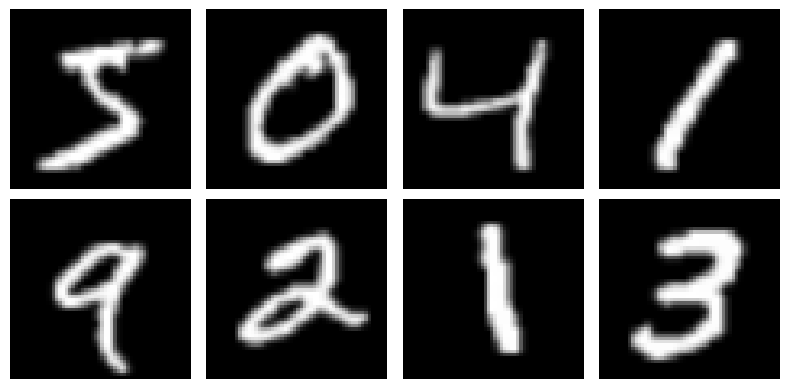

In [7]:
#51_03 - UpSampling 2D: MNIST 영상 확대
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

#1:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
print(x_train.shape)

# expand data with channel = 1 ## 채널 축을 추가
x_train = np.expand_dims(x_train,axis = 3)      # (60000, 28, 28, 1)
x_test  = np.expand_dims(x_test, axis = 3)      # (10000, 28, 28, 1)
print(x_train.shape)

#3: build a model
model = tf.keras.Sequential()
# shape[1:]은 0차원을 제외한 나머지 차원을 준다
model.add(tf.keras.layers.Input(x_train.shape[1:])) # shape = (28, 28, 1)
model.add(tf.keras.layers.UpSampling2D(interpolation='bilinear')) # size =(2,2)
model.summary()

#4: apply x_train to model
#  x_train[:8]은 slicing으로 0부터 7까지 slicing
output = model.predict(x_train[:8])  # (8, 56, 56, 1)
img = output[:,:,:,0]                # 0-channel
print("img.shape=", img.shape)

#5: display images
fig = plt.figure(figsize = (8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img[i], cmap = 'gray')
    plt.axis("off")
fig.tight_layout()
plt.show()


**Step 52 전치 합성곱**

In [ ]:
#52_01 - 전치 합성곱(Conv2DTranspose) 계산과정을 보여주는 코드
## 입력에 대하여 padding과 stride를 적용하여 출력을 더 크게 만들어준다
## 전치 합성곱은 이미지 분할 과 이미지 생성에 사용된다, 입력 이미지를 크게 늘려서 점점 더 세밀한 부분까지 분할
# strides = (1,1)로 전치 합성곱을 계산
import tensorflow as tf
import numpy as np

#1:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2: crate a 2D input data
A = np.array([[1, 2],
              [3, 4 ]],dtype='float32')
A = A.reshape(-1, 2, 2, 1)

#3: kernel
W = np.array([[ 1,  -1],
               [ 2,  -2]], dtype = 'float32')
W = W.reshape(2, 2, 1, 1)   # (kernel_size[0], kernel_size[1], filters, channels)

#4: build a model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(A.shape[1:])) # shape = (2, 2, 1)
model.add(tf.keras.layers.Conv2DTranspose(filters=1,
                                 kernel_size = (2, 2),# 커널의 회전이 전치
                                 strides = (1, 1),
                                 padding = 'valid',  # 'same'
                                 use_bias = False,
                                 kernel_initializer = tf.constant_initializer(W)))
model.summary()
##model.set_weights([W]) # kernel_initializer = tf.constant_initializer(W)

#5: apply A to model
B = model.predict(A)     # (batch, new_rows, new_cols, filters)
print("B.shape=", B.shape)
print("B[0,:,:,0]=\n", B[0,:,:,0])

#6: weights
##W1 = model.get_weights() # W, model.trainable_variables
##print("W1[0].shape=", W1[0].shape)
##print("W1[0]=\n", W1[0])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_1 (Conv2DT  (None, 3, 3, 1)          4         
 ranspose)                                                       
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 56ms/step
B.shape= (1, 3, 3, 1)
B[0,:,:,0]=
 [[ 1.  1. -2.]
 [ 5.  3. -8.]
 [ 6.  2. -8.]]


In [ ]:
#52_02 -Conv2DTranspose: strides = (2,2)로 전치 합성곱
import tensorflow as tf
import numpy as np

#1:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2: crate a 2D input data
A = np.array([[1, 2],
              [3, 4 ]],dtype='float32')
A = A.reshape(-1, 2, 2, 1)

#3: kernel
W = np.array([[ 1,  -1],
              [ 2,  -2]], dtype = 'float32')
W = W.reshape(2, 2, 1, 1)   # (kernel_size[0], kernel_size[1], filters, channels)

#4: build a model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(A.shape[1:])) # shape = (2, 2, 1)
model.add(tf.keras.layers.Conv2DTranspose(filters=1,
                                 kernel_size = (2, 2),
                                 strides = (2, 2), # 수정한 코드
                                 padding = 'valid',  # 'same'
                                 use_bias = False,
                                 kernel_initializer = tf.constant_initializer(W)))
model.summary()
##model.set_weights([W]) # kernel_initializer = tf.constant_initializer(W)

#5: apply A to model
B = model.predict(A)     # (batch, new_rows, new_cols, filters)
print("B.shape=", B.shape) # output.shape = (1,4,4,1)
print("B[0,:,:,0]=\n", B[0,:,:,0])

#6: weights
##W1 = model.get_weights() # W, model.trainable_variables
##print("W1[0].shape=", W1[0].shape)
##print("W1[0]=\n", W1[0])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_2 (Conv2DT  (None, 4, 4, 1)          4         
 ranspose)                                                       
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 57ms/step
B.shape= (1, 4, 4, 1)
B[0,:,:,0]=
 [[ 1. -1.  2. -2.]
 [ 2. -2.  4. -4.]
 [ 3. -3.  4. -4.]
 [ 6. -6.  8. -8.]]


In [8]:
#52_03 - Conv2DTranspose: strides = (2,2), 2-channels
# 다채널 전치 합성곱은 채널별로 계산하고, 요소별로 합하여 하나로 출력
import tensorflow as tf
import numpy as np

#1:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2: crate a 2D input with 2 channels
A = np.array([[[1, 2],           # 0-channel
               [3, 4]],
              [[1, 2],           # 1-channel
               [3, 4]]], dtype = 'float32')
##print("A.shape", A.shape)         # (channels, rows, cols) = (2, 2, 2)
A = np.transpose(A, (1, 2, 0))      # (rows, cols, channels) = (2, 2, 2)
A= np.expand_dims(A, axis = 0)      # (batch,rows, cols, channels)=(1, 2, 2, 2)

#3: kernel with 2-channels
W = np.array([[[1, -1],           # 0-channel
               [2, -2]],
              [[1, -1],           # 1-channel
               [2, -2]]], dtype = 'float32')
##print("W.shape", W.shape)         # (channels, rows, cols) = (2, 2, 2)
W = np.transpose(W, (1, 2, 0))      # (rows, cols, channels) = (2, 2, 2)
W= np.expand_dims(W, axis = 2)      # (rows, cols, filters, channels) = (2, 2, 1, 2)

#4: build a model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(A.shape[1:])) # shape = (2, 2, 2)
model.add(tf.keras.layers.Conv2DTranspose(filters=1,
                                 kernel_size = (2, 2),
                                 strides = (2, 2),
                                 padding = 'valid', # 'same
                                 use_bias = False,
                                 kernel_initializer = tf.constant_initializer(W)))
model.summary()

#5: apply A to model
B = model.predict(A)     # (batch, new_rows, new_cols, filters)
print("B.shape=", B.shape) # B.shape = (1,4,4,1) - 두 채널의 결과를 요소별로 더한 값
print("B[0,:,:,0]=\n", B[0,:,:,0])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 4, 4, 1)          8         
 nspose)                                                         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 196ms/step
B.shape= (1, 4, 4, 1)
B[0,:,:,0]=
 [[  2.  -2.   4.  -4.]
 [  4.  -4.   8.  -8.]
 [  6.  -6.   8.  -8.]
 [ 12. -12.  16. -16.]]


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_1 (Conv2DT  (None, 56, 56, 1)        4         
 ranspose)                                                       
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 108ms/step
img.shape= (8, 56, 56)


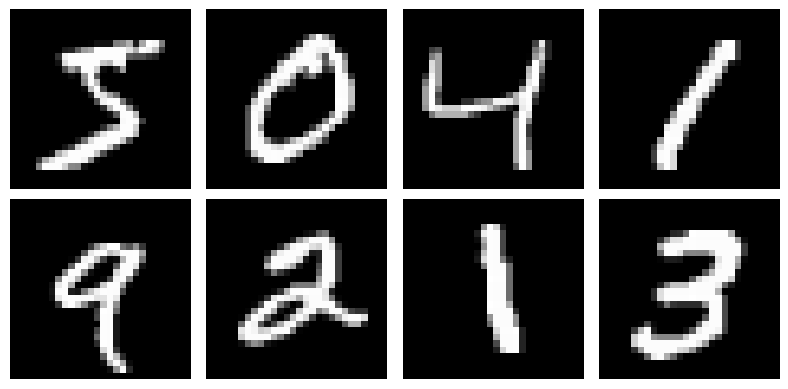

In [9]:
#52_04 - Conv2DTranspose: MNIST 영상 확대
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

#1:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

# expand data with channel = 1
x_train = np.expand_dims(x_train,axis = 3)      # (60000, 28, 28, 1)
x_test  = np.expand_dims(x_test, axis = 3)      # (10000, 28, 28, 1)

#3: kernel
W = np.array([[ 1,  1],
              [ 1,  1]], dtype = 'float32')
W = W.reshape(2, 2, 1, 1)   # (kernel_size[0], kernel_size[1], filters, channels)

#4: build a model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(x_train.shape[1:])) # shape = (28, 28, 1)
model.add(tf.keras.layers.Conv2DTranspose(filters=1,
                                 kernel_size = (2, 2),
                                 strides = (2, 2),
                                 padding = 'valid',
                                 use_bias = False,
                                 kernel_initializer = tf.constant_initializer(W)))
model.summary()

#5: apply x_train to model
output = model.predict(x_train[:8])  # (8, 56, 56, 1)
img = output[:,:,:,0]                # 0-filters
print("img.shape=", img.shape)

#6: display images
fig = plt.figure(figsize = (8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img[i], cmap = 'gray')
    plt.axis("off")
fig.tight_layout()
plt.show()


**STEP 53 오토 인코더**

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 8)                 88        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
Total params: 124
Trainable params: 124
Non-trainable params: 0
_________________________________________________________________


<ipython-input-10-26d2de0b8e4f>:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [16,  0, 15,  5, 11,  9,  8, 12, 43, 37]], dtype=np.float)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 10)]              0         
                                                                 
 model (Functional)          (None, 4)                 124       
                                                                 
 model_1 (Functional)        (None, 10)                130       
                                                                 
Total params: 254
Trainable params: 254
Non-trainable params: 0
_________________________________________________________________
x=
 tf.Tensor(
[[ 3.6849668   0.          0.          0.        ]
 [ 0.74513185  2.2727313   0.5771498   0.        ]
 [ 0.          6.5202675   0.          3.6234043 ]
 [ 0.42046857  3.0327322   3.3443484   3.7123115 ]
 [10.903757    6.3142366   4.2377014   0.        ]], shape=(5, 4), dtype=float32)
B=
 tf.Tensor(
[[-0.2223

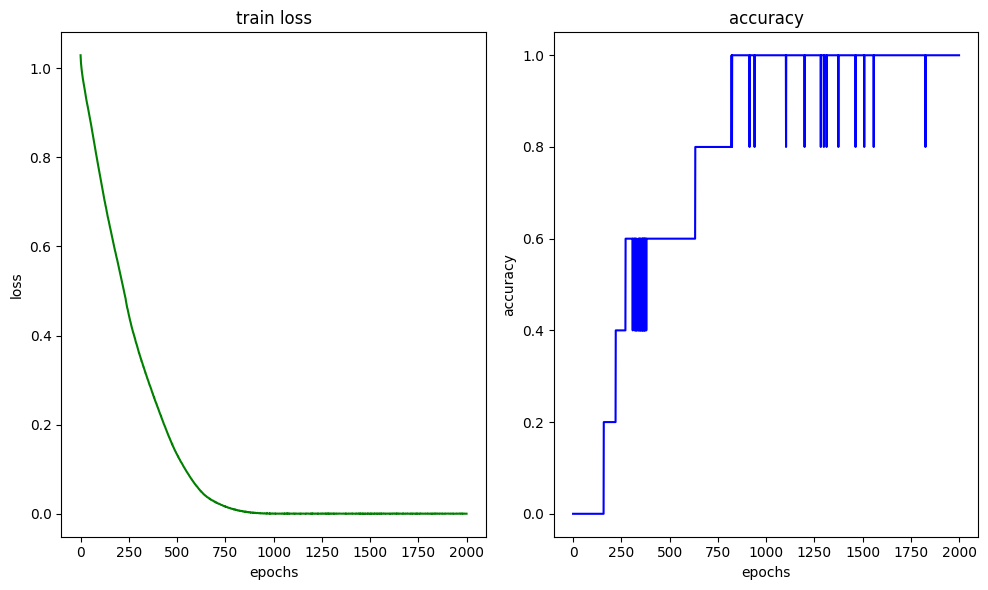

In [10]:
#53_01 - Autoencoder
## 인코더: down sampling, 디코더: up sampling
## 입력에 대한 label이 필요없는 unsupervised learning > 차원 축소, 노이즈 제거에 사용됨
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import numpy as np
import matplotlib.pyplot as plt

#1:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2:
#np.random.seed(1)
#X = np.arange(50)
#np.random.shuffle(X)
#X = X.reshape(-1, 10)
# 10 차원 벡터 5개를 입력
X = np.array([[27, 35, 40, 38,  2,  3, 48, 29, 46, 31],
              [32, 39, 21, 36, 19, 42, 49, 26, 22, 13],
              [41, 17, 45, 24, 23,  4, 33, 14, 30, 10],
              [28, 44, 34, 18, 20, 25,  6,  7, 47,  1],
              [16,  0, 15,  5, 11,  9,  8, 12, 43, 37]], dtype=np.float)
# normalize
##A = X/np.max(X)
mX = np.mean(X, axis = 0)
std = np.std(X, axis = 0)
A = (X - mX)/std

#3: autoencoder model
#3-1:
encode_dim = 4  # latent_dim - 차원 축소 - 4차원으로
input_x = Input(shape = (10,))  #  A.shape[1:]
encode= Dense(units = 8, activation = 'relu')(input_x)
encode= Dense(units = encode_dim, activation = 'relu')(encode)
encoder = tf.keras.Model(inputs= input_x, outputs= encode) # 4차원으로 축소하는 encoder 모델
encoder.summary()
# 잠재적 벡터 latent vector = encoder(input_x)
#3-2:
decode_input = Input(shape = (encode_dim,))
decode= Dense(units = 8, activation = 'relu')(decode_input)
decode= Dense(units = 10, activation = None)(decode)
decoder = tf.keras.Model(inputs= decode_input, outputs= decode)
decoder.summary

#3-3:
autoencoder  = tf.keras.Model(inputs = input_x,  outputs = decoder(encoder(input_x)))
autoencoder.summary()

#4: train the model
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.001) #'rmsprop'
autoencoder.compile(optimizer = opt, loss= 'mse', metrics = ['accuracy'])
ret = autoencoder.fit(A, A, epochs = 2000, batch_size= 3, verbose=0)

#5:
x = encoder(A) # 잠재적 벡터
print("x=\n", x)

B = decoder(x)  # B = autoencoder(A), hat(X) = B*std + mX
print("B=\n", B)
print("A=\n", A)  # input
print("np.abs(A - B)=\n", np.abs(A - B))

#6:
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax[0].plot(ret.history['loss'], "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].plot(ret.history['accuracy'], "b-")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
fig.tight_layout()
plt.show()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 model_3 (Functional)        (None, 32)                52320     
                                                                 
 model_4 (Functional)        (None, 28, 28)            53072     
                                                                 
Total params: 105,392
Trainable params: 105,392
Non-trainable params: 0
_________________________________________________________________


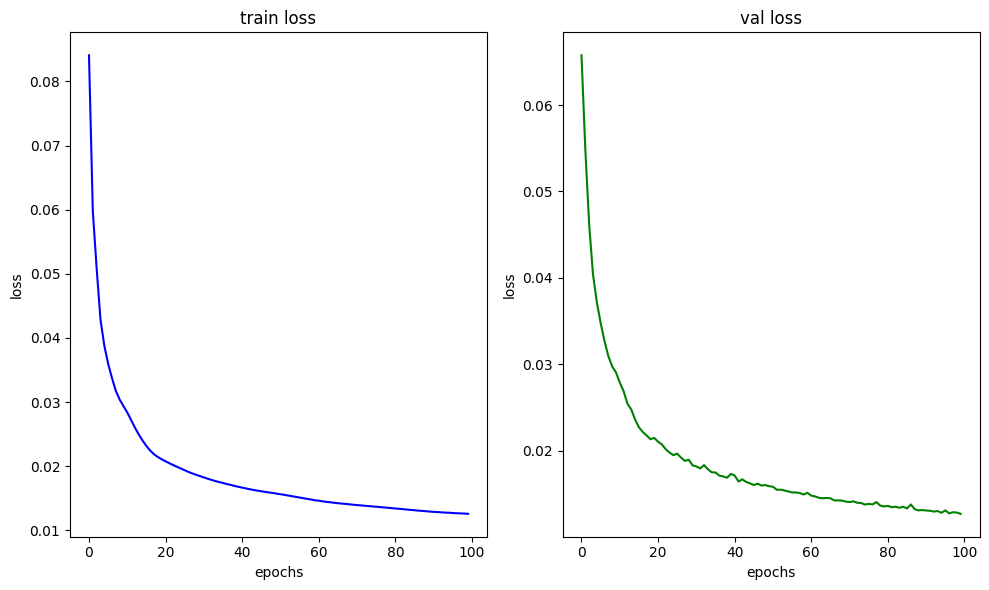

F.shape= (8, 32)
img.shape= (8, 28, 28)


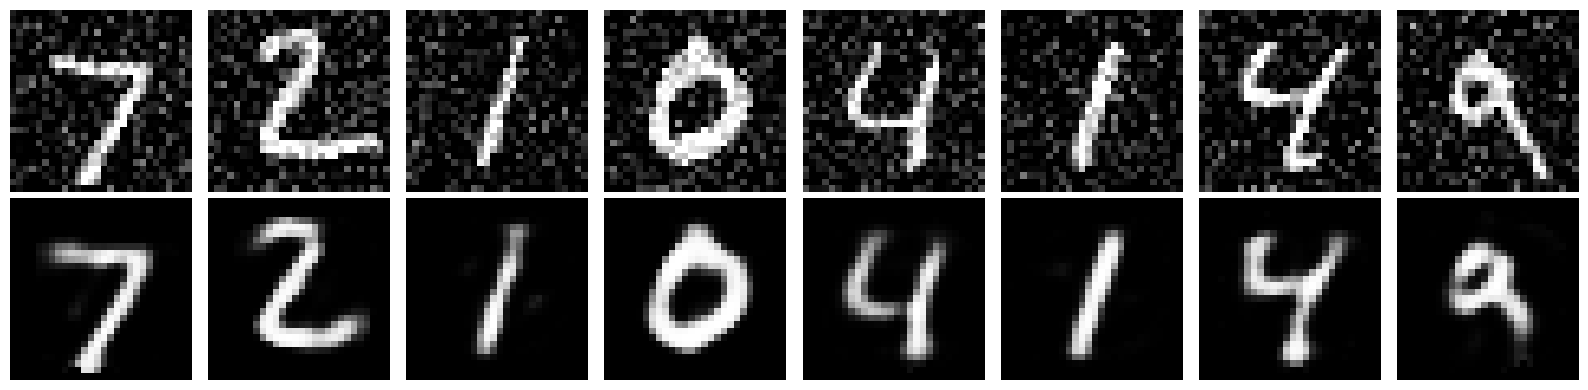

In [11]:
#53_02 Dense: MNIST Autoencoder - 잡음 제거를 구현 - 20분 이상 걸림
'''
ref1: https://towardsdatascience.com/autoencoders-in-keras-c1f57b9a2fd7
ref2: https://towardsdatascience.com/how-to-make-an-autoencoder-2f2d99cd5103
ref3: https://blog.keras.io/building-autoencoders-in-keras.html
'''
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
import numpy as np
import matplotlib.pyplot as plt

#1:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255
x_test  = x_test.astype('float32')/255

#3: add noise to dataset - 노이즈를 추가
x_train_noise = x_train + np.random.normal(loc=0.0, scale=0.2, size=x_train.shape)
x_test_noise  = x_test  + np.random.normal(loc=0.0, scale=0.2, size=x_test.shape)
x_train_noise = np.clip(x_train_noise, 0, 1) # 배열의 원소들을 지정한 범위로 제한
x_test_noise = np.clip(x_test_noise, 0, 1)

#4: autoencoder model
#4-1:
encode_dim = 32 # latent_dim
input_x = Input(shape = (28, 28)) #  x_train.shape[1:]
encode  = Flatten()(input_x) # 784 차원
encode= Dense(units = 64, activation = 'relu')(encode)
encode= Dense(units = encode_dim, activation = 'relu')(encode) # 32차원으로 축소
encoder = tf.keras.Model(inputs= input_x, outputs= encode)
##encoder.summary()

#4-2:
decode_input = Input(shape = (encode_dim,))
decode= Dense(units = 64, activation = 'relu')(decode_input)
decode= Dense(units = 784, activation ='sigmoid')(decode)
decode= Reshape((28, 28))(decode)
decoder = tf.keras.Model(inputs= decode_input, outputs= decode)
##decoder.summary

#4-3:
autoencoder  = tf.keras.Model(inputs = input_x,  outputs = decoder(encoder(input_x)))
autoencoder.summary()

#5: train the model
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.001) #'rmsprop'
autoencoder.compile(optimizer = opt, loss= 'mse' ) # 'binary_crossentropy'
# 노이즈 추가된 데이터를 입력, 노이즈가 없는 데이터를 출력으로 학습
ret = autoencoder.fit(x=x_train_noise, y=x_train, epochs= 100, batch_size= 128, # 입력에 대해서 출력이 얼마나 잘되는지 확인
                       validation_split = 0.2, verbose = 0)

#6:
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax[0].plot(ret.history['loss'], "b-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].plot(ret.history['val_loss'], "g-")
ax[1].set_title("val loss")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')
fig.tight_layout()
plt.show()

#7: apply  x_test_noise[:8] to model and display
F = encoder(x_test_noise[:8])
print("F.shape=", F.shape)

img = decoder(F)  # img = autoencoder(x_test_noise[:8])
print("img.shape=", img.shape)


#8: display images
fig = plt.figure(figsize = (16, 4))
for i in range(16):
    plt.subplot(2, 8, i + 1)
    if i<8: # noise
        plt.imshow(x_test_noise[i], cmap = 'gray')
    else:   # reconstructed
        plt.imshow(img[i-8], cmap = 'gray')
    plt.axis("off")

fig.tight_layout()
plt.show()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 784)               0   

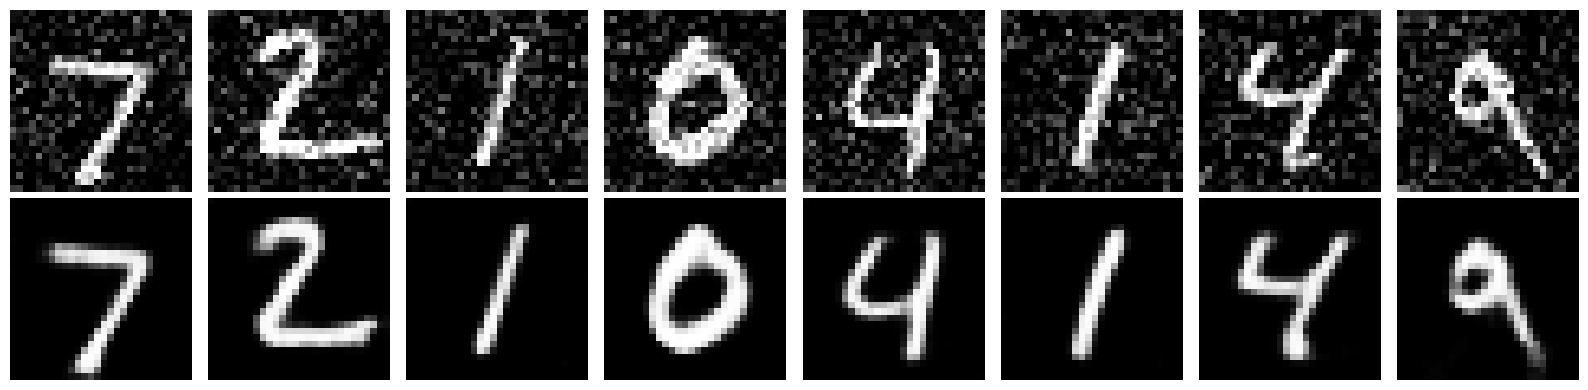

In [3]:
#53_03 - 합성곱 신경망: MNIST Autoencoder, Conv2D, Conv2DTranspose로 잡음 제거 구현 - 실행시간 많이 걸린다 - 개인실습 확인
'''
ref1:https://towardsdatascience.com/autoencoders-in-keras-c1f57b9a2fd7
ref2:
https://medium.com/analytics-vidhya/building-a-convolutional-autoencoder-using-keras-using-conv2dtranspose-ca403c8d144e
'''
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense,  Flatten, Reshape, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D

import numpy as np
import matplotlib.pyplot as plt

#1:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255
x_test  = x_test.astype('float32')/255

# expand data with channel = 1
x_train = np.expand_dims(x_train,axis = 3)     # (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis = 3)      # (10000, 28, 28, 1)

#3: add noise to dataset ## 노이즈 추가
x_train_noise = x_train + np.random.normal(loc=0.0, scale=0.2, size=x_train.shape) # 평균 loc = 0.0, 표준편차 scale = 0.2 잡음을 추가
x_test_noise  = x_test  + np.random.normal(loc=0.0, scale=0.2, size=x_test.shape)
x_train_noise = np.clip(x_train_noise, 0, 1) # 0 ~ 1 사이 값을 제한
x_test_noise = np.clip(x_test_noise, 0, 1)

#4: autoencoder model
#4-1:
encode_dim = 32  # latent_dim
input_x= Input(shape = x_train.shape[1:]) #  (28, 28, 1)
encode= Conv2D(filters=32,kernel_size=(3,3), padding='same', activation = 'relu')(input_x)
encode= MaxPool2D()(encode) # (14, 14, 32)

encode= Conv2D(filters= 16, kernel_size= (3, 3), padding='same', activation = 'relu')(encode)
encode= MaxPool2D()(encode) # (7, 7, 16) - 차원 축소
encode= Flatten()(encode)

encode= Dense(units = encode_dim, activation = 'relu')(encode) # 32차원으로 축소
encoder = tf.keras.Model(inputs= input_x, outputs= encode, name ='encoder')
encoder.summary()

#4-2: decoder by (Conv2D + UpSampling2D) or Conv2DTranspose
decode_input = Input(shape = (encode_dim,))
encode= Dense(units = 7*7*4, activation = 'relu')(decode_input) # 확장
decode= Reshape((7, 7, 4))(encode)

##decode=Conv2D(filters=16, kernel_size = (3, 3), strides = (1, 1),
##                 activation = 'relu', padding = 'same')(decode)
##decode=UpSampling2D()(decode) # size =(2,2)
decode=Conv2DTranspose(filters=16, kernel_size = (3, 3), strides = (2, 2),
                           activation = 'relu', padding = 'same')(decode)

##decode=Conv2D(filters=32, kernel_size = (3, 3), strides = (1, 1),
##                 activation = 'relu', padding = 'same')(decode)
##decode=UpSampling2D()(decode)
decode=Conv2DTranspose(filters=32, kernel_size = (3, 3), strides = (2, 2),
                           activation = 'relu', padding = 'same')(decode)
# 업샘플링으로  Conv2D, Conv2DTranspose를 사용
decode=Conv2D(filters=1, kernel_size = (3, 3), strides = (1, 1),
              activation = 'sigmoid', padding = 'same')(decode)
decoder = tf.keras.Model(inputs= decode_input, outputs= decode, name ='decoder')
decoder.summary()

#4-3
autoencoder  = tf.keras.Model(inputs = input_x,
                            outputs = decoder(encoder(input_x)), name ='autoencoder')
autoencoder.summary()

#5: train the model
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.001) #'rmsprop'
autoencoder.compile(optimizer = opt, loss= 'mse' ) #  'binary_crossentropy'
ret = autoencoder.fit(x=x_train_noise, y=x_train, epochs= 100, batch_size= 128,
                       validation_split = 0.2, verbose = 2)

#6:
##fig, ax = plt.subplots(1, 2, figsize = (10, 6))
##ax[0].plot(ret.history['loss'], "b-")
##ax[0].set_title("train loss")
##ax[0].set_xlabel('epochs')
##ax[0].set_ylabel('loss')
##
##ax[1].plot(ret.history['val_loss'], "g-")
##ax[1].set_title("val loss")
##ax[1].set_xlabel('epochs')
##ax[1].set_ylabel('loss')
##fig.tight_layout()
##plt.show()

#7: apply  x_test_noise[:8] to model and display
F = encoder(x_test_noise[:8])
print("F.shape=", F.shape)

img = decoder(F)  # img = autoencoder(x_test_noise[:8])
img = img.numpy()
img = img.reshape(-1, 28, 28)
print("img.shape=", img.shape)

#8: display images
fig = plt.figure(figsize = (16, 4))
for i in range(16):
    plt.subplot(2, 8, i + 1)
    if i<8: # noise
        plt.imshow(x_test_noise[i,:,:,0], cmap = 'gray')
    else:   # reconstructed
        plt.imshow(img[i-8], cmap = 'gray')
    plt.axis("off")

fig.tight_layout()
plt.show()


**STEP 54 GAN 모델**

Model: "G"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2816      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         

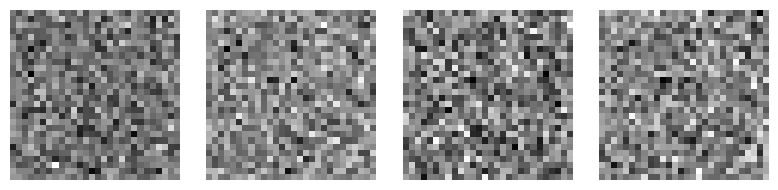

In [12]:
#54_01 - GAN 생성모델 ## unsupervised learning
'''
ref1: https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko
ref2: https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py
'''
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
import numpy as np
import matplotlib.pyplot as plt

#1:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/127.5 - 1.0  # [ -1, 1] ## 정규화
x_train = x_train.reshape(-1, 784)

#3: G, D using Sequential - Sequential 모델로 MNIST 데이터세트 학습을 위한 생성모델 G, 분류 모델 D를 생성
noise_dim = 10 # 100 ## 노이즈 벡터 dim

#3-1: generator, G
##G = Sequential()
##G.add(Dense(256, input_dim=noise_dim ))
##G.add(LeakyReLU(alpha=0.2))
##G.add(Dense(512))
##G.add(LeakyReLU(alpha=0.2))
##G.add(Dense(1024))
##G.add(LeakyReLU(alpha=0.2))
##G.add(Dense(784, activation='tanh')) #[-1, 1] ##데이터세트과 같은 차원 출력 위해
##G.compile(loss='binary_crossentropy', optimizer='rmsprop')

#3-2:discriminator, D
##D = Sequential()
##D.add(Dense(1024, input_dim=784)) ## 벡터 차원 784를 입력으
##D.add(LeakyReLU(alpha=0.2))
##D.add(Dropout(0.3))

##D.add(Dense(512))
##D.add(LeakyReLU(alpha=0.2))
##D.add(Dropout(0.3))
##D.add(Dense(256))
##D.add(LeakyReLU(alpha=0.2))
##D.add(Dropout(0.3))
##D.add(Dense(1, activation='sigmoid')) # sigmoid 를 사용하고 units = 1로 판별한다.
##D.compile(loss='binary_crossentropy', optimizer='rmsprop')

#4: G, D using Model ##함수형 모델로 구현
noise_dim = 10 # 100
#4-1
g_input = Input(shape = (noise_dim, ))
x= Dense(units = 256)(g_input)
x= LeakyReLU(alpha=0.2)(x)
x= Dense(units = 512)(x)
x= LeakyReLU(alpha=0.2)(x)
x= Dense(units = 1024)(x)
x= LeakyReLU(alpha=0.2)(x)
g_out= Dense(784, activation='tanh')(x) # [-1, 1]
G = Model(inputs= g_input, outputs= g_out, name="G")
G.summary()
##G.compile(loss='binary_crossentropy', optimizer='rmsprop')


#4-2: discriminator, D
d_input = Input(shape = (784, ))
x= Dense(units = 1024)(d_input)
x= LeakyReLU()(x)
x= Dropout(0.3)(x)

x= Dense(units = 512)(x)
x= LeakyReLU()(x)
x= Dropout(0.3)(x)

x= Dense(units = 256)(x)
x= LeakyReLU()(x)
x= Dropout(0.3)(x)
d_out= Dense(1, activation='sigmoid')(x)
D = Model(inputs= d_input, outputs= d_out, name="D")
D.summary()
##D.compile(loss='binary_crossentropy', optimizer='rmsprop')

#5: GAN
##D.trainable = False
gan_input = Input(shape=(noise_dim,))
x = G(gan_input)
gan_output = D(x)
GAN = Model(inputs=gan_input, outputs=gan_output, name="GAN")
GAN.summary()
##gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

#6
batch_size = 4
noise = tf.random.normal([batch_size, noise_dim])
fake = G(noise)
out = D(fake)   # out= D(G(noise)), GAN(noise), out= GAN.predict(noise)
print('out=', out)
##print('GAN(noise)=', GAN(noise))
##print('D(x_train[:batch_size])=', D(x_train[:batch_size]))

fig = plt.figure(figsize = (8, 2))
for i in range(batch_size):
    plt.subplot(1, 4, i + 1)
    plt.imshow(fake[i].numpy().reshape((28, 28)), cmap = 'gray')
    plt.axis("off")
fig.tight_layout()
plt.show()

In [14]:
### tensor version 확인
print(tf.__version__)
### 2.10 version 사용
!pip install tensorflow~=2.10.0
### 실행후 런타임 다시 시작

2.12.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 49.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator

In [ ]:
#54_02 GAN 모델 - 15분 걸려도 끝나지 않음
'''
ref1: https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko
ref2: https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py
'''
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, LeakyReLU, Dropout
import numpy as np
import matplotlib.pyplot as plt

#1:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/127.5 - 1.0  # [ -1, 1]
x_train = x_train.reshape(-1, 784)

##opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0002)

#3: create model
#3-1: generator, G
noise_dim = 100
g_input = Input(shape = (noise_dim, ))
x= Dense(units = 256)(g_input)
x= LeakyReLU(alpha=0.2)(x)
x= Dense(units = 512)(x)
x= LeakyReLU(alpha=0.2)(x)
x= Dense(units = 1024)(x)
x= LeakyReLU(alpha=0.2)(x)
g_out= Dense(784, activation='tanh')(x) # [-1, 1]
G = Model(inputs= g_input, outputs= g_out, name="G")
G.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
##G.summary()

#3-2: discriminator, D
d_input = Input(shape = (784, ))
x= Dense(units = 1024)(d_input)
x= LeakyReLU()(x)
x= Dropout(0.3)(x)
x= Dense(units = 512)(x)
x= LeakyReLU()(x)
x= Dropout(0.3)(x)
x= Dense(units = 256)(x)
x= LeakyReLU()(x)
x= Dropout(0.3)(x)
d_out= Dense(1, activation='sigmoid')(x)
D = Model(inputs= d_input, outputs= d_out, name="D")
D.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
##D.summary() # In model D, D.trainable = True is fixed by D.compile()

#3-3: GAN model
D.trainable = False
gan_input = Input(shape=(noise_dim,))
DCGAN = Model(inputs=gan_input, outputs=D(G(gan_input)), name="GAN")
DCGAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
##GAN.summary() # In GAN, D.trainable = False is fixed by GAN.compile()

#4:
import os
if not os.path.exists("./GAN"):
     os.mkdir("./GAN")
def plotGeneratedImages(epoch, examples=20, dim=(2, 10), figsize=(10, 2)):
    noise = np.random.normal(0, 1, size=[examples, noise_dim])
    g_image = G.predict(noise)
    g_image = g_image.reshape(examples, 28, 28)
    g_image = (g_image + 1.0)*127.5
    g_image = g_image.astype('uint8')

    plt.figure(figsize=figsize)
    for i in range(g_image.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(g_image[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("./GAN/gan_epoch_%d.png"% epoch)
    plt.close()

#5:
BUFFER_SIZE = x_train.shape[0] # 60000
BATCH_SIZE  = 128
batch_count = np.ceil(BUFFER_SIZE/BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

history = {"g_loss":[], "g_acc":[], "d_loss":[], "d_acc":[]}
def train(epochs=100):
    for epoch in range(epochs):
        dloss = 0.0
        gloss = 0.0
        dacc  = 0.0
        gacc  = 0.0

        for batch in train_dataset:  # batch.shape = (BATCH_SIZE, 784)
            batch_size = batch.shape[0]
            noise = tf.random.normal([batch_size, noise_dim])
            fake = G.predict(noise)  # fake.shape = (batch_size, 784)
            X = np.concatenate([batch, fake]) # X.shape = (2*batch_size, 784)

            # labels for fake = 0, real(batch) = 1
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 1.0

            # train discriminator, D
            ret = D.train_on_batch(X, y_dis) # D.trainable = True
            dloss += ret[0] # loss
            dacc  += ret[1] # accuracy

            # train generator, G
            noise = tf.random.normal([batch_size, noise_dim])
            #noise = tf.cast(noise, dtype=tf.float32)
            y_gen = np.ones(batch_size)
            #y_gen = tf.cast(y_gen, dtype=tf.float32)
            ### 2.12 tensor version에서 error 발생
            ret= DCGAN.train_on_batch(noise, y_gen) # D.trainable = False
            ###
            gloss += ret[0]
            gacc  += ret[1]
        avg_gloss = gloss/batch_count
        avg_gacc  = gacc/batch_count
        avg_dloss = dloss/batch_count
        avg_dacc  = dacc/batch_count

        print("epoch={}: G:(loss= {:.4f}, acc={:.1f}), D:(loss= {:.4f}, acc={:.1f})".format(epoch, avg_gloss,100*avg_gacc, avg_dloss, 100*avg_dacc))
        history["g_loss"].append(avg_gloss)
        history["g_acc"].append(avg_gacc)
        history["d_loss"].append(avg_dloss)
        history["d_acc"].append(avg_dacc)

        if epoch % 20 == 0 or epoch == epochs-1:
            plotGeneratedImages(epoch)

train()

#6:
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax[0].plot(history["g_loss"], "g-", label = "G losses")
ax[0].plot(history["d_loss"], "b-", label = "D losses")
ax[0].set_title("train loss")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].legend()

ax[1].plot(history["g_acc"], "g-",  label = "G accuracy")
ax[1].plot(history["d_acc"], "b-",  label = "D accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()
fig.tight_layout()
plt.show()


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
3/3 [==============================] - 0s 11ms/step
epoch=81: G:(loss= 0.8279, acc=34.7), D:(loss= 0.6579, acc=60.4)
3/3 [==============================] - 0s 22ms/step
epoch=82: G:(loss= 0.8289, acc=34.7), D:(loss= 0.6584, acc=60.4)
3/3 [==============================] - 0s 11ms/step
epoch=83: G:(loss= 0.8251, acc=35.1), D:(loss= 0.6581, acc=60.4)
3/3 [==============================] - 0s 13ms/step
epoch=84: G:(loss= 0.8292, acc=34.8), D:(loss= 0.6583, acc=60.5)
3/3 [==============================] - 0s 22ms/step
epoch=85: G:(loss= 0.8274, acc=34.6), D:(loss= 0.6585, acc=60.5)
3/3 [==============================] - 0s 13ms/step
epoch=86: G:(loss= 0.8331, acc=34.8), D:(loss= 0.6567, acc=60.7)
3/3 [==============================] - 0s 23ms/step
epoch=87: G:(loss= 0.8300, acc=34.6), D:(loss= 0.6575, acc=60.5)
3/3 [==============================] - 0s 12ms/step
epoch=88: G:(loss= 0.8338, acc=34.5), D:(loss= 0.6569, acc=60.5)
3/3 [=======================

In [5]:
#54_03
'''
ref1: https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko
ref2: https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_dcgan.py
'''
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, LeakyReLU, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt

#1:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/127.5 - 1.0  # [ -1, 1]
x_train = np.expand_dims(x_train, axis=3)        # (60000, 28, 28, 1)

opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0002)
##opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)

##init_lr = 0.0002
##lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
##              init_lr, decay_steps=469*10*2, decay_rate=0.96, staircase=True)
##opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

#3: create model
#3-1: generator, G
noise_dim = 100
g_input = Input(shape = (noise_dim, ))
x= Dense(units = 7*7*128, activation = 'relu')(g_input)
x= Reshape((7, 7, 128))(x)
x= Conv2DTranspose(filters=64, kernel_size = (3, 3), strides = (2, 2),
                   activation = 'relu', padding = 'same')(x)
x= BatchNormalization()(x)
x= Conv2DTranspose(filters=32, kernel_size = (3, 3), strides = (2, 2),
                   activation = 'relu', padding = 'same')(x)
x= BatchNormalization()(x)

g_output= Conv2D(filters=1, kernel_size = (3, 3), strides = (1, 1),
              activation = 'tanh', padding = 'same')(x) # (None, 28, 28, 1)
G= Model(inputs= g_input, outputs= g_output, name ='G')
G.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
G.summary()

#3-2: discriminator, D
d_input = Input(shape = (28, 28, 1))
x= Conv2D(32, kernel_size=3, strides=2, padding="same")(d_input)
x= LeakyReLU()(x)
x= Dropout(0.3)(x)

x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
x= LeakyReLU()(x)
x= Dropout(0.3)(x)

x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
x= LeakyReLU()(x)
x= Dropout(0.3)(x)

x = Flatten()(x)
d_output = Dense(1, activation='sigmoid')(x)

D = Model(inputs= d_input, outputs= d_output, name="D")
D.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
D.summary()

#3-3: GAN model
D.trainable = False
gan_input = Input(shape=(noise_dim,))
DCGAN = Model(inputs=gan_input, outputs=D(G(gan_input)), name="GAN")
DCGAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
DCGAN.summary()

#4:
import os
if not os.path.exists("./GAN"):
     os.mkdir("./GAN")

def plotGeneratedImages(epoch, examples=20, dim=(2, 10), figsize=(10, 2)):
    noise = np.random.normal(0, 1, size=[examples, noise_dim])
    g_image = G.predict(noise)
    g_image = np.squeeze(g_image, axis = 3)

    g_image = (g_image + 1.0)*127.5
    g_image = g_image.astype('uint8')

    plt.figure(figsize=figsize)
    for i in range(g_image.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(g_image[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("./GAN/dcgan_epoch_%d.png"% epoch)
    plt.close()

#5:
BUFFER_SIZE = x_train.shape[0] # 60000
BATCH_SIZE  = 128
batch_count = np.ceil(BUFFER_SIZE/BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

history = {"g_loss":[], "g_acc":[], "d_loss":[], "d_acc":[]}
def train(epochs=100):

    for epoch in range(epochs):
        dloss = 0.0
        gloss = 0.0
        dacc  = 0.0
        gacc  = 0.0

##      batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
##      print("epoch = ", D.optimizer._decayed_lr('float32').numpy())

        for batch in train_dataset:  # batch.shape = (BATCH_SIZE, 28, 28, 1)
            batch_size = batch.shape[0]

            noise = tf.random.normal([batch_size, noise_dim])
            fake = G.predict(noise)  # fake.shape = (batch_size, 784)
            X = np.concatenate([batch, fake]) # X.shape = (2*batch_size, 784)

            # labels for fake = 0, batch = 1
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 1.0

            # train discriminator, D
            ret = D.train_on_batch(X, y_dis) # D.trainable = True
            dloss += ret[0] # loss
            dacc  += ret[1] # accuracy

            # train generator, G
            noise = tf.random.normal([batch_size, noise_dim])
            y_gen = np.ones(batch_size)
            ret= DCGAN.train_on_batch(noise, y_gen) # D.trainable = False
            gloss += ret[0]
            gacc  += ret[1]

        avg_gloss = gloss/batch_count
        avg_gacc  = gacc/batch_count

        avg_dloss = dloss/batch_count
        avg_dacc  = dacc/batch_count


        print("epoch={}: G:(loss= {:.4f}, acc={:.1f}), D:(loss= {:.4f}, acc={:.1f})".format(
            epoch, avg_gloss,100*avg_gacc, avg_dloss, 100*avg_dacc))
        history["g_loss"].append(avg_gloss)
        history["g_acc"].append(avg_gacc)
        history["d_loss"].append(avg_dloss)
        history["d_acc"].append(avg_dacc)

        if epoch % 20 == 0 or epoch == epochs-1:
            plotGeneratedImages(epoch)
train(100)

#6:
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax[0].plot(history["g_loss"], "g-", label = "G losses")
ax[0].plot(history["d_loss"], "b-", label = "D losses")
ax[0].set_title("train loss")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].legend()

ax[1].plot(history["g_acc"], "g-",  label = "G accuracy")
ax[1].plot(history["d_acc"], "b-",  label = "D accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()
fig.tight_layout()
plt.show()


Model: "G"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 64)       73792     
 ranspose)                                                       
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 32)       18464     

KeyError: in user code:

    File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1054, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\optimizer.py", line 543, in minimize
        self.apply_gradients(grads_and_vars)
    File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\optimizer.py", line 1174, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\optimizer.py", line 650, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\optimizer.py", line 1200, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\optimizer.py", line 1250, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\optimizer.py", line 1247, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\optimizer.py", line 232, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable dense_4/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.RMSprop.'
